In [1]:
%run ../0-utils/0-Base.ipynb

Read data that will be used for training / testing:

In [2]:
%%time

feature_matrix_dfs = dict()

for feature_matrix_clazz in ("train", "test"):
    feature_matrix_df = pd.read_csv(f"../data/2-feature-engineered/{feature_matrix_clazz}.csv")
    feature_matrix_df = feature_matrix_df.drop("MODE(transactions.merchant_id)", axis=1)
    feature_matrix_df = feature_matrix_df.replace([np.inf, -np.inf], np.nan)
    feature_matrix_df = feature_matrix_df.set_index("card_id")
    
    display(feature_matrix_df)

    feature_matrix_dfs[feature_matrix_clazz] = feature_matrix_df

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),SUM(transactions.merchants.ID),SUM(transactions.merchants.merchant_group_id),SUM(transactions.merchants.merchant_category_id),SUM(transactions.merchants.subsector_id),SUM(transactions.merchants.numerical_1),SUM(transactions.merchants.numerical_2),SUM(transactions.merchants.avg_sales_lag3),SUM(transactions.merchants.avg_purchases_lag3),SUM(transactions.merchants.active_months_lag3),SUM(transactions.merchants.avg_sales_lag6),SUM(transactions.merchants.avg_purchases_lag6),SUM(transactions.merchants.active_months_lag6),SUM(transactions.merchants.avg_sales_lag12),SUM(transactions.merchants.avg_purchases_lag12),SUM(transactions.merchants.active_months_lag12),SUM(transactions.merchants.city_id),SUM(transactions.merchants.state_id),STD(transactions.merchants.ID),STD(transactions.merchants.merchant_group_id),STD(transactions.merchants.merchant_category_id),STD(transactions.merchants.subsector_id),STD(transactions.merchants.numerical_1),STD(transactions.merchants.numerical_2),STD(transactions.merchants.avg_sales_lag3),STD(transactions.merchants.avg_purchases_lag3),STD(transactions.merchants.active_months_lag3),STD(transactions.merchants.avg_sales_lag6),STD(transactions.merchants.avg_purchases_lag6),STD(transactions.merchants.active_months_lag6),STD(transactions.merchants.avg_sales_lag12),STD(transactions.merchants.avg_purchases_lag12),STD(transactions.merchants.active_months_lag12),STD(transactions.merchants.city_id),STD(transactions.merchants.state_id),MAX(transactions.merchants.ID),MAX(transactions.merchants.merchant_group_id),MAX(transa

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),SUM(transactions.merchants.ID),SUM(transactions.merchants.merchant_group_id),SUM(transactions.merchants.merchant_category_id),SUM(transactions.merchants.subsector_id),SUM(transactions.merchants.numerical_1),SUM(transactions.merchants.numerical_2),SUM(transactions.merchants.avg_sales_lag3),SUM(transactions.merchants.avg_purchases_lag3),SUM(transactions.merchants.active_months_lag3),SUM(transactions.merchants.avg_sales_lag6),SUM(transactions.merchants.avg_purchases_lag6),SUM(transactions.merchants.active_months_lag6),SUM(transactions.merchants.avg_sales_lag12),SUM(transactions.merchants.avg_purchases_lag12),SUM(transactions.merchants.active_months_lag12),SUM(transactions.merchants.city_id),SUM(transactions.merchants.state_id),STD(transactions.merchants.ID),STD(transactions.merchants.merchant_group_id),STD(transactions.merchants.merchant_category_id),STD(transactions.merchants.subsector_id),STD(transactions.merchants.numerical_1),STD(transactions.merchants.numerical_2),STD(transactions.merchants.avg_sales_lag3),STD(transactions.merchants.avg_purchases_lag3),STD(transactions.merchants.active_months_lag3),STD(transactions.merchants.avg_sales_lag6),STD(transactions.merchants.avg_purchases_lag6),STD(transactions.merchants.active_months_lag6),STD(transactions.merchants.avg_sales_lag12),STD(transactions.merchants.avg_purchases_lag12),STD(transactions.merchants.active_months_lag12),STD(transactions.merchants.city_id),STD(transactions.merchants.state_id),MAX(transactions.merchants.ID),MAX(transactions.merchants.merchant_group_id),MAX(transa

CPU times: user 11.9 s, sys: 947 ms, total: 12.8 s
Wall time: 12.8 s


Check for missing values:

In [3]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    print(feature_matrix_clazz.upper() + ":")
    
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    display(cols_with_nulls)

TRAIN:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)',
 'SUM(transactions.merchants.avg_purchases_lag3)',
 'SUM(transactions.merchants.avg_purchases_lag6)',
 'SUM(transactions.merchants.avg_purchases_lag12)',
 'STD(transactions.merchants.avg_purchases_lag3)',
 'STD(transactions.merchants.avg_purchases_lag6)',
 'STD(transactions.merchants.avg_purchases_lag12)',
 'MAX(transactions.merchants.avg_purchases_lag3)',
 'MAX(transactions.merchants.avg_purchases_lag6)',
 'MAX(transactions.merchants.avg_purchases_lag12)',
 'SKEW(transactions.merchants.ID)',
 'SKEW(transactions.merchants.merchant_group_id)',
 'SKEW(transactions.merchants.merchant_category_id)',
 'SKEW(transactions.merchants.subsector_id)',
 'SKEW(transactions.merchants.numerical_1)',
 'SKEW(transactions.merchants.numerical_2)',
 'SKEW(transactions.merchants.avg_sales_lag3)',
 'SKEW(transactions.merchants.avg_purchases_lag3)',
 'SKEW(transactions.merchants.active_months_lag3)',
 'S

TEST:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)',
 'SUM(transactions.merchants.avg_purchases_lag3)',
 'SUM(transactions.merchants.avg_purchases_lag6)',
 'SUM(transactions.merchants.avg_purchases_lag12)',
 'STD(transactions.merchants.avg_purchases_lag3)',
 'STD(transactions.merchants.avg_purchases_lag6)',
 'STD(transactions.merchants.avg_purchases_lag12)',
 'MAX(transactions.merchants.avg_purchases_lag3)',
 'MAX(transactions.merchants.avg_purchases_lag6)',
 'MAX(transactions.merchants.avg_purchases_lag12)',
 'SKEW(transactions.merchants.ID)',
 'SKEW(transactions.merchants.merchant_group_id)',
 'SKEW(transactions.merchants.merchant_category_id)',
 'SKEW(transactions.merchants.subsector_id)',
 'SKEW(transactions.merchants.numerical_1)',
 'SKEW(transactions.merchants.numerical_2)',
 'SKEW(transactions.merchants.avg_sales_lag3)',
 'SKEW(transactions.merchants.avg_purchases_lag3)',
 'SKEW(transactions.merchants.active_months_lag3)',
 'S

Get rid of missing values:

In [4]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    for col in cols_with_nulls: feature_matrix_df[col].fillna(feature_matrix_df[col].mode()[0], inplace=True)
    print(f"{feature_matrix_clazz.upper()} has {feature_matrix_df.isnull().sum().sum()} missing values!")

TRAIN has 0 missing values!
TEST has 0 missing values!


In [5]:
X_train, y_train = feature_matrix_dfs["train"].drop("target", axis=1), feature_matrix_dfs["train"].target

X_test = feature_matrix_dfs["test"].drop("target", axis=1)

In [11]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, max_features="log2", max_depth=13, n_jobs=-1, random_state=13)
scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3))
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 3.7605 +/- 0.0020
CPU times: user 9.87 s, sys: 729 ms, total: 10.6 s
Wall time: 49.1 s


In [7]:
%%time

model.fit(X_train, y_train)

CPU times: user 2min 34s, sys: 136 ms, total: 2min 34s
Wall time: 19.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

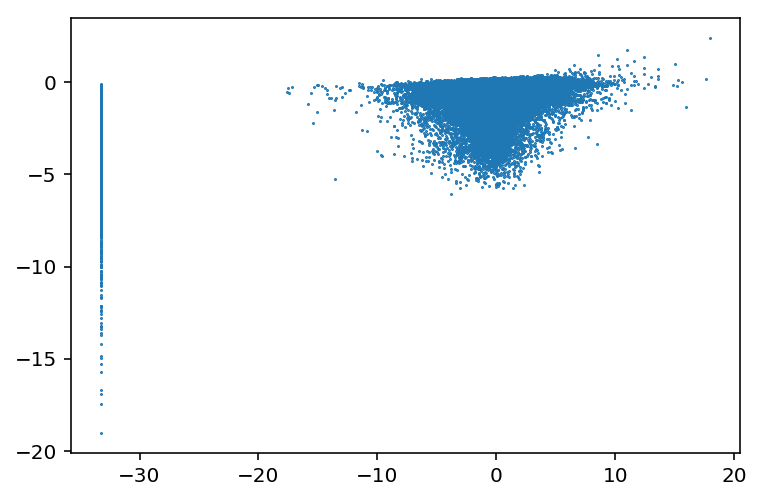

In [8]:
plt.scatter(y_train, model.predict(X_train), s=0.25);

In [9]:
%%time

y_test = model.predict(X_test)

CPU times: user 4.13 s, sys: 160 ms, total: 4.29 s
Wall time: 723 ms


In [10]:
submission_df = feature_matrix_dfs["test"].assign(target=y_test).loc[:, ["target"]]

display(submission_df)
    
submission_df.to_csv("../submission.csv")

,target
card_id,
C_ID_0079d1f5ee,-0.164479
C_ID_00d20cfaa6,-0.145896
C_ID_023ee72d50,-0.160238
...,...
C_ID_fe91e3fc9f,-0.074700
C_ID_ff02b057f5,0.020519
C_ID_ffbb1f9527,-0.128585
